In [1]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.spatial import distance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import AgglomerativeClustering
import plotly.io as pio
pio.kaleido.scope.default_format = "pdf"
from matplotlib.colors import ListedColormap
import matplotlib.colors as mc
import plotly.graph_objects as gomerge_TAD_expression
import sys
sys.path.insert(0, '/home/data4/jh/data/tools/customized/tadtools/tadtool_pkg')
import utils as ut
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema

In [2]:
def check(a):
    try:
        r=float(a)
    except ValueError:
        r=np.nan
    return r
cols = (11,13,14,15)
data = np.loadtxt('../data/TAD_ChIP_strength_fpkm_size_E1_interaction_twoborerexpression_innerfpkm.tsv',delimiter='\t',skiprows=1,usecols=cols,converters = {k: check for k in cols})
data_all = pd.read_csv('../data/TAD_ChIP_strength_fpkm_size_E1_interaction_twoborerexpression_innerfpkm.tsv',delimiter='\t',converters = {k: check for k in cols})
data_all = data_all[~np.isnan(data).any(axis=1)]
# data_all.columns = ['chrom','start','end','PC1 values','expression']
# data_all['size'] = data_all['end']-data_all['start']
# data_all = data_all.apply(lambda x : pd.to_numeric(x,errors='coerce'))
data = data[~np.isnan(data).any(axis=1)]
np.set_printoptions(precision=3, suppress=True)
#data = np.genfromtxt(data)

In [5]:
data.shape

(2650, 3)

In [122]:
#data_m = data/data.sum(axis=0,keepdims=1)*1000000
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
data_m = np.apply_along_axis(normalize_data,0,data)
mean = np.mean(data_m,axis=0)
st_d = np.std(data_m,axis=0)
distance_from_mean = abs(data_m-mean)
max_d = 2
not_out = distance_from_mean < max_d*st_d
#not_out
no_out = data_m[np.sum(not_out,axis=1)==3,:]
print(data_m.shape,no_out.shape)
data_sq = distance.cdist(no_out,no_out,'sqeuclidean')
# data_cos = distance.cdist(data_m,data_m,'cosine')

(2111, 4) (302, 4)


,chrom,start,end,H3K9me3_RPKM,H3K36me3_RPKM,H3K4me1_RPKM,POU5F1_RPKM,H3K27me3_RPKM,NANOG_RPKM,CTCF_RPKM,H3K4me3_RPKM,E1,expression,strength,border_fpkm,size,interaction,E1.1
0,chr1,4440000,4800000,0.714689,3.081767,3.183183,0.762644,0.720414,0.993484,0.821859,2.843474,0.252871641,30.949375,0.243850,0.000000,360000.0,0.001827,0.001045
1,chr1,4840000,6200000,0.233456,3.438194,2.542468,0.842724,0.222650,1.005763,0.841192,2.932617,0.07828551383,19.03833333,0.978933,84.542500,1360000.0,0.000961,-0.005504
2,chr1,6240000,6920000,0.700055,1.443003,0.285463,0.588748,0.461818,0.564777,0.681681,0.273189,-0.08600333175,2.690833333,0.351045,15.485000,680000.0,0.001943,-0.014799
3,chr1,6960000,8200000,0.560486,0.379240,0.214082,0.618727,0.394839,0.622525,0.755855,0.260735,-0.02904784383,4.065,0.961099,0.000000,1240000.0,0.000388,0.000543
4,chr1,8240000,9520000,1.578950,1.520725,1.213257,0.618981,0.360319,0.708752,0.778033,2.703058,-0.02914024571,62.815,0.395564,0.000000,1280000.0,0.000511,-0.005020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,chr19,57720000,59240000,0.939361,0.403295,0.452610,0.716896,1.987057,0.838989,0.741580,0.866588,0.06794090514,0.932,NaN,0.000000,1520000.0,0.000752,-0.033262
2578,chr19,59280000,60400000,0.508993,1.500364,0.309162,0.688251,0.716206,0.706369,0.817836,0.307092,-0.2829541914,156.257,NaN,3.755000,1120000.0,0.002275,-0.041698
2598,chrX,23600000,36440000,0.282714,0.314218,0.166442,0.214361,0.239294,0.191339,0.567560,0.099752,.,1.177291667,NaN,0.000000,12840000.0,0.000292,0.013123
2634,chrX,73680000,74000000,0.134776,3.720219,2.133402,0.407143,0.159294,0.469485,0.502765,1.626094,1.256896527,43.51785714,NaN,36.486667,320000.0,0.005012,0.016895


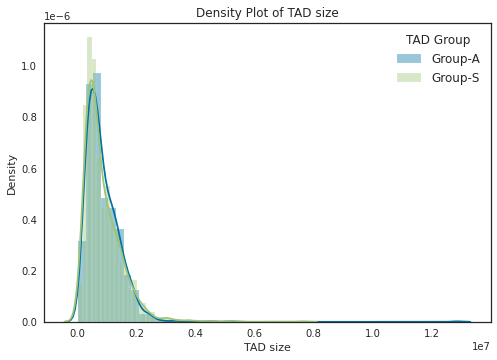

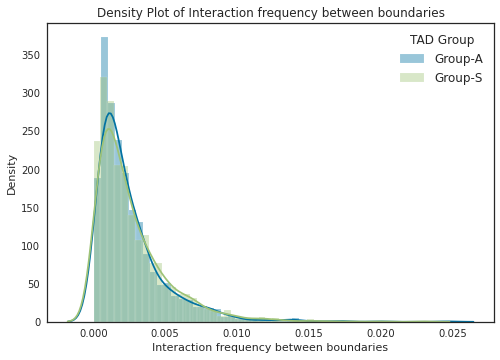

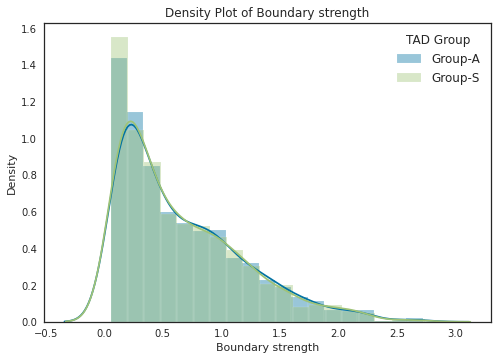

In [155]:
#penguins = sns.load_dataset("penguins")
#penguins
#df = pd.DataFrame(data_m, columns = ['boundary strength','size','PC1 values','interaction between boundaries'])
## estimate threshold
# kde_est = sns.distplot(df["PC1 values"], kde=True).get_lines()[0].get_data()
# mi, ma = argrelextrema(kde_est[1], np.less)[0], argrelextrema(kde_est[1], np.greater)[0]
# threshold = kde_est[0][mi[0]]

fig, axs = plt.subplots()
sns.set_style('ticks')
sns.distplot(tad_1['size'],label='Group-A')
sns.distplot(tad_2['size'],label='Group-S')
plt.legend(prop={'size': 12}, title = 'TAD Group')
plt.title('Density Plot of TAD size')
plt.xlabel('TAD size')
plt.ylabel('Density')
plt.savefig('./results/size2.pdf',bbox_inches='tight')

fig, axs = plt.subplots()
sns.set_style('ticks')
sns.distplot(tad_1['interaction'],label='Group-A')
sns.distplot(tad_2['interaction'],label='Group-S')
plt.legend(prop={'size': 12}, title = 'TAD Group')
plt.title('Density Plot of Interaction frequency between boundaries')
plt.xlabel('Interaction frequency between boundaries')
plt.ylabel('Density')
plt.savefig('./results/interaction2.pdf',bbox_inches='tight')

fig, axs = plt.subplots()
sns.set_style('ticks')
sns.distplot(tad_1['strength'],label='Group-A')
sns.distplot(tad_2['strength'],label='Group-S')
plt.legend(prop={'size': 12}, title = 'TAD Group')
plt.title('Density Plot of Boundary strength')
plt.xlabel('Boundary strength')
plt.ylabel('Density')
plt.savefig('./results/strength2.pdf',bbox_inches='tight')
# 
# sns.set_style('ticks')
# sns.displot(tad_1['interaction'],kind='kde')
# sns.displot(tad_2['interaction'],kind='kde')
# plt.savefig('./results/interaction2.pdf',bbox_inches='tight')
# sns.set_style('ticks')
# sns.displot(df,x='PC1 values',kind='kde')
# plt.axvline(threshold, linestyle="--")
# plt.xlim(0,1)
# plt.savefig('./results/PC1values_norm_dist.pdf',bbox_inches='tight')
# sns.displot(df, x = "size", kind="kde")
# plt.savefig('./results/size_norm_dist.pdf',bbox_inches='tight')
# sns.displot(df, x = "interaction between boundaries", kind="kde")
# plt.savefig('./results/interaction_norm_dist.pdf',bbox_inches='tight')

# sns.displot(df, x = "size", kind="kde")
# plt.savefig('./results/size_norm_dist.pdf',bbox_inches='tight')

In [2]:
tad_1 = pd.read_csv('S_TAD.tsv',sep='\t')
tad_2 = pd.read_csv('A_TAD.tsv',sep='\t')

In [6]:
from scipy.stats import mannwhitneyu
U1, p1 = mannwhitneyu(tad_1['size'],tad_2['size'])
U2, p2 = mannwhitneyu(tad_1['interaction'],tad_2['interaction'])
U3, p3 = mannwhitneyu(tad_1['strength'],tad_2['strength'])

In [7]:
p1,p2,p3

(0.030771505439681705, 0.2538681784100981, 0.00044395422792464935)

In [126]:
pc1 = data_m[:,2]
s_tad = data_all[pc1 <= threshold]
a_tad = data_all[pc1 > threshold]
s_tad.to_csv('./results/S_2_TADs.bed',sep='\t',index=False,quoting=3)
a_tad.to_csv('./results/A_2_TADs.bed',sep='\t',index=False,quoting=3)

In [8]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=3)
y_pred = clustering.fit(data_m)
from collections import Counter
Counter(y_pred.labels_)

Counter({0: 1308, 1: 941, 2: 401})

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

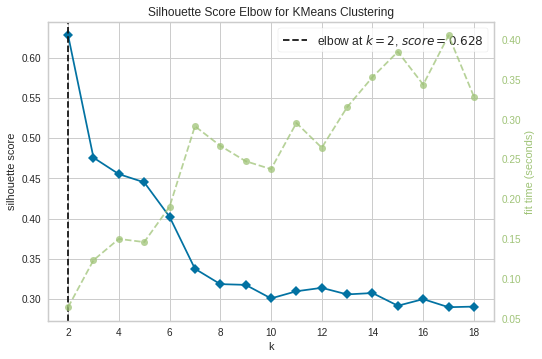

In [30]:
# sum_of_squared_distances = []
# K = range(1,20)
# for k in K:
#     y_pred = AgglomerativeClustering(linkage='ward', n_clusters=k).fit(data_m)
#     sum_of_squared_distances.append(y_pred.inertia_)
# Silhouette Score for AgglomerativeClustering

model = AgglomerativeClustering(linkage='ward')
model_k = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model_k, k=(2,19),metric='silhouette', timings= True)
visualizer.fit(data_m)        # Fit the data to the visualizer
visualizer.show(outpath='./results/merge_kmeans_3_elbow.pdf')        # Finalize and render the figure

In [103]:
#a = data_m[:,2].reshape(-1,1)
# #a = array([10,11,9,23,21,11,45,20,11,12]).reshape(-1, 1)
#kde = stats.gaussian_kde(a)
# kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(a)
# s = linspace(-1,1)
# e = kde.score_samples(s.reshape(-1,1))
# plot(s, e)
#plt.savefig('./results/merge_PC1values_kernel.pdf',bbox_inches='tight')
mi, ma = argrelextrema(kde_est[1], np.less)[0], argrelextrema(kde_est[1], np.greater)[0]
threshold = kde_est[0][mi[0]]
pc1 = data_m[:,2]
# tad_1 = data_all[a<=a[ma]]
# tad_2 = data_all[a>a[ma]]
# print('Grouping by HAS QUIT:')
print(pc1[pc1 <= threshold], pc1[pc1 > threshold])
# print('Grouping by yasirroni:')
# print(a[a < s[mi][0]], a[(a >= s[mi][0]) * (a <= s[mi][1])], a[a >= s[mi][1]])

[0.506 0.397 0.512 0.482 0.494 0.321 0.308 0.356 0.302 0.379 0.357 0.352
 0.309 0.295 0.322 0.526 0.339 0.374 0.413 0.383 0.3   0.348 0.467 0.409
 0.455 0.299 0.392 0.247 0.264 0.232 0.234 0.258 0.259 0.245 0.406 0.422
 0.351 0.358 0.214 0.259 0.521 0.265 0.291 0.3   0.285 0.293 0.377 0.247
 0.266 0.372 0.261 0.233 0.517 0.485 0.241 0.272 0.252 0.256 0.274 0.257
 0.256 0.298 0.245 0.276 0.302 0.277 0.287 0.259 0.459 0.278 0.434 0.436
 0.462 0.346 0.322 0.419 0.429 0.313 0.383 0.319 0.401 0.478 0.392 0.341
 0.463 0.462 0.482 0.529 0.413 0.421 0.494 0.383 0.339 0.366 0.456 0.433
 0.473 0.485 0.514 0.362 0.451 0.528 0.469 0.481 0.499 0.396 0.383 0.375
 0.345 0.373 0.425 0.44  0.342 0.281 0.335 0.312 0.268 0.286 0.384 0.269
 0.295 0.507 0.421 0.517 0.264 0.252 0.277 0.319 0.254 0.457 0.321 0.239
 0.254 0.308 0.272 0.271 0.257 0.409 0.239 0.367 0.254 0.278 0.241 0.268
 0.248 0.255 0.245 0.248 0.29  0.255 0.52  0.329 0.356 0.387 0.241 0.263
 0.286 0.239 0.338 0.305 0.254 0.473 0.272 0.442 0.

In [57]:
tad_1.to_csv('S_TAD.tsv',sep='\t',index=False,quoting=3)
tad_2.to_csv('A_TAD.tsv',sep='\t',index=False,quoting=3)

In [17]:
y_pred_3 = KMeans(n_clusters=3, random_state=170,max_iter=3000,precompute_distances=False,algorithm='full').fit(data_sq)
labels = y_pred_3.labels_
metrics.silhouette_score(no_out, labels, metric='sqeuclidean')

0.7318294935572325

In [13]:
simplet1 = no_out[y_pred.labels_==0,:]
simplet2 = no_out[y_pred.labels_==1,:]
simplet3 = no_out[y_pred.labels_==2,:]
simplesort = np.concatenate((simplet1,simplet2,simplet3),axis=0)

In [16]:
fig = go.Figure(data=go.Heatmap(
                    z=simplesort))
fig.update_layout(template='simple_white',title_text='Agglomerative Cluster',xaxis = dict(showgrid=False,ticks='inside',mirror=True,
                                                                                   showline=True,tickmode = 'array',
                                                                                          tickvals = np.arange(3),
                                                                                          ticktext=['expression on boundaries','TAD size','cis-Eigenvalue 1']),
                yaxis = dict(showgrid=False, ticks='outside',mirror=True,showline=True,tickmode = 'array',tickvals = [985,985+565,985+565+400],
                            ticktext = ['Type1','Type2','Type3']),
                font=dict(size=18),
                 title_x=0.5,
                 showlegend=False)
                  
fig.write_image('./data/AggloCluster3signal_norm.pdf')

In [35]:
data_chip = np.loadtxt('TAD_ChIP_strength_fpkm_size_E1_interaction.tsv',delimiter='\t',skiprows=1,usecols=(3,4,5,6,7,8,9,10))
data_chip_no_out = data_chip[np.sum(not_out,axis=1)==3,:]
data_chip_type1 = data_chip_no_out[y_pred.labels_==0,:]
data_chip_type2 = data_chip_no_out[y_pred.labels_==1,:]

In [44]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=4)
y_pred = clustering.fit(data_chip_type1)
from collections import Counter
Counter(labels)

Counter({1: 505, 2: 367, 3: 196, 0: 46})

In [40]:
t1t1 = data_chip_type1[y_pred.labels_==0,:]
t1t2= data_chip_type1[y_pred.labels_==1,:]
t1t3 = data_chip_type1[y_pred.labels_==2,:]
t1t4 = data_chip_type1[y_pred.labels_==3,:]
t1sort = np.concatenate((t1t1,t1t2,t1t3,t1t4),axis=0)
cluster1_header = pd.read_csv('Cluster1.tsv',sep='\t',nrows=1,header=None,usecols=(3,4,5,6,7,8,9,10))
fig = go.Figure(data=go.Heatmap(
                    z=t1sort))
fig.update_layout(template='simple_white',title_text='Agglomerative Cluster',xaxis = dict(showgrid=False,ticks='inside',mirror=True,
                                                                                   showline=True,tickmode = 'array',
                                                                                         tickvals = np.arange(len(cluster1_header.to_numpy().ravel())),
                                                                                          ticktext=cluster1_header.to_numpy().ravel()),
                yaxis = dict(showgrid=False, ticks='outside',mirror=True,showline=True,tickmode = 'array',tickvals = [171,171+328,171+328+288,171+328+288+327],
                            ticktext = ['Type1','Type2','Type3','Type4']),
                font=dict(size=18),
                 title_x=0.5,
                 showlegend=False)
                  
fig.write_image('AggloCluster8signal.pdf')

In [42]:
data_sq = distance.cdist(data_chip_type1,data_chip_type1,'sqeuclidean')
y_pred_4 = KMeans(n_clusters=4, random_state=170,max_iter=3000,precompute_distances=False,algorithm='full').fit(data_sq)
labels = y_pred_4.labels_
metrics.silhouette_score(data_chip_type1, labels, metric='sqeuclidean')

0.3303806554817509

In [47]:
t1t1 = data_chip_type1[labels==0,:]
t1t2= data_chip_type1[labels==1,:]
t1t3 = data_chip_type1[labels==2,:]
t1t4 = data_chip_type1[labels==3,:]
t1sort = np.concatenate((t1t1,t1t2,t1t3,t1t4),axis=0)
cluster1_header = pd.read_csv('Cluster1.tsv',sep='\t',nrows=1,header=None,usecols=(3,4,5,6,7,8,9,10))
fig = go.Figure(data=go.Heatmap(
                    z=t1sort))
fig.update_layout(template='simple_white',title_text='Kmeans Cluster',xaxis = dict(showgrid=False,ticks='inside',mirror=True,
                                                                                   showline=True,tickmode = 'array',
                                                                                         tickvals = np.arange(len(cluster1_header.to_numpy().ravel())),
                                                                                          ticktext=cluster1_header.to_numpy().ravel()),
                yaxis = dict(showgrid=False, ticks='outside',mirror=True,showline=True,tickmode = 'array',tickvals = [46,46+505,46+505+367,46+505+367+196],
                            ticktext = ['Type1','Type2','Type3','Type4']),
                font=dict(size=18),
                 title_x=0.5,
                 showlegend=False)
                  
fig.write_image('KmeansCluster8signal.pdf')

In [52]:
clustering = AgglomerativeClustering(linkage='ward', n_clusters=3)
y_pred = clustering.fit(data_chip_type2)
Counter(y_pred.labels_)

Counter({2: 427, 1: 142, 0: 165})

In [53]:
t2t1 = data_chip_type2[y_pred.labels_==0,:]
t2t2= data_chip_type2[y_pred.labels_==1,:]
t2t3 = data_chip_type2[y_pred.labels_==2,:]
#t2t4 = data_chip_type2[y_pred.labels_==3,:]
t1sort = np.concatenate((t2t1,t2t2,t2t3),axis=0)
cluster1_header = pd.read_csv('Cluster1.tsv',sep='\t',nrows=1,header=None,usecols=(3,4,5,6,7,8,9,10))
fig = go.Figure(data=go.Heatmap(
                    z=t1sort))
fig.update_layout(template='simple_white',title_text='Agglomerative Cluster',xaxis = dict(showgrid=False,ticks='inside',mirror=True,
                                                                                   showline=True,tickmode = 'array',
                                                                                         tickvals = np.arange(len(cluster1_header.to_numpy().ravel())),
                                                                                          ticktext=cluster1_header.to_numpy().ravel()),
                yaxis = dict(showgrid=False, ticks='outside',mirror=True,showline=True,tickmode = 'array',tickvals = [165,165+142,165+142+427],
                            ticktext = ['Type1','Type2','Type3']),
                font=dict(size=18),
                 title_x=0.5,
                 showlegend=False)
                  
fig.write_image('AggloCluster8signal_2_3.pdf')

In [6]:
data_all_not_out = data_all.loc[np.sum(not_out,axis=1)==3,:]
data_all_not_out.loc[y_pred.labels_==0,:].to_csv('Agglo_Cluster1.tsv',sep='\t',index=False,quoting=3)
data_all_not_out.loc[y_pred.labels_==1,:].to_csv('Agglo_Cluster2.tsv',sep='\t',index=False,quoting=3)
data_all_not_out.loc[y_pred.labels_==2,:].to_csv('Agglo_Cluster3.tsv',sep='\t',index=False,quoting=3)

In [112]:
chromosome = ['chr'+ i for i in [str(i) for i in range(1,20)]]
chromosome.append('chrX')
def to_borders(C1,name):
#C1 = data_not_out.loc[labels==0,:]
    for chrom in chromosome:
        data_chr = C1.loc[C1.chrom==chrom]
        borders_start = np.sort(np.unique(np.append(data_chr.start.to_numpy()-40000,data_chr.end.to_numpy())))
        borders_end = borders_start+40000
        with open(f'{name}_borders.bed','a') as fo:
            for i in range(len(borders_start)):
                fo.write(f'{chrom}\t{borders_start[i]}\t{borders_end[i]}\n')

In [8]:
to_borders(data_all_not_out.loc[y_pred.labels_==0,:],'Agglo_C1')
to_borders(data_all_not_out.loc[y_pred.labels_==1,:],'Agglo_C2')
to_borders(data_all_not_out.loc[y_pred.labels_==2,:],'Agglo_C3')

In [3]:
data_1 = pd.read_csv('/home/data4/jh/data/projects/2020/aggregate/data/explain/Agglo_Cluster1.tsv',sep='\t')
data_2 = pd.read_csv('/home/data4/jh/data/projects/2020/aggregate/data/explain/Agglo_Cluster2.tsv',sep='\t')
data_3 = pd.read_csv('/home/data4/jh/data/projects/2020/aggregate/data/explain/Agglo_Cluster3.tsv',sep='\t')

In [5]:
to_borders(data_1,'Agglo_C1')
to_borders(data_2,'Agglo_C2')
to_borders(data_3,'Agglo_C3')

In [114]:
to_borders(data_all,'all_nanexclu')
# to_borders(s_tad,'S')
# to_borders(a_tad,'A')